In [2]:
# Gap Statistic Method

# Imports
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
style.use('ggplot')

In [78]:
# Generate data
X, y = make_blobs(400, centers=6)

In [79]:
# Generate cluster labels
labels_list = []
clusterers = []
for n_clusters in range(1, 10):
    clusterer = KMeans(init='k-means++', n_clusters=n_clusters)
    labels_list.append(clusterer.fit_predict(X))
    clusterers.append(clusterer)

In [80]:
# Code modified from https://datasciencelab.wordpress.com/2013/12/27/finding-the-k-in-k-means-clustering/
def Wk(X, labels):
    distances = pairwise_distances(X) ** 2
    unique_labels = np.unique(labels)
    n_samples_per_label = np.bincount(labels, minlength=len(unique_labels))
    intra_clust_dists = np.zeros(len(unique_labels))
    
    for curr_label in range(len(unique_labels)):
        mask = labels == curr_label
        current_distances = distances[mask]
        n_samples_curr_lab = n_samples_per_label[curr_label]
        if n_samples_curr_lab != 0:
            intra_clust_dists[curr_label] = np.sum(np.sum(
                current_distances[:, mask], axis=1)) / (2 * n_samples_curr_lab)
    return np.sum(intra_clust_dists)

def bounding_box(X):
    n_dims = len(X.shape)
    mins = []
    maxs = []
    for dim in range(n_dims):
        mins.append(min(X,key=lambda a:a[dim])[dim])
        maxs.append(max(X,key=lambda a:a[dim])[dim])
    return mins, maxs

def gap_statistic(X, label_list, clusterers):
    ks = range(1, len(label_list) + 1)
    mins, maxs = bounding_box(X)
    # Dispersion for real distribution
    Wks = np.zeros(len(ks))
    Wkbs = np.zeros(len(ks))
    sk = np.zeros(len(ks))
    for indk, k in enumerate(ks):
        Wks[indk] = np.log(Wk(X, label_list[indk]))
        # Create B reference datasets
        B = 10
        BWkbs = np.zeros(B)
        for i in range(B):
            Xb = []
            for n in range(len(X)):
                distribs = []
                for j in range(len(mins)):
                    distribs.append(np.random.uniform(mins[j], maxs[j]))
                Xb.append(distribs)
            Xb = np.array(Xb)
            clusterer = clusterers[indk]
            Xb_labels = clusterer.fit_predict(Xb)
            BWkbs[i] = np.log(Wk(Xb, Xb_labels))
        Wkbs[indk] = sum(BWkbs)/B
        sk[indk] = np.sqrt(sum((BWkbs-Wkbs[indk])**2)/B)
    sk = sk*np.sqrt(1+1/B)
    return(ks, Wks, Wkbs, sk)

ks, Wks, Wkbs, sk = gap_statistic(X, labels_list, clusterers)

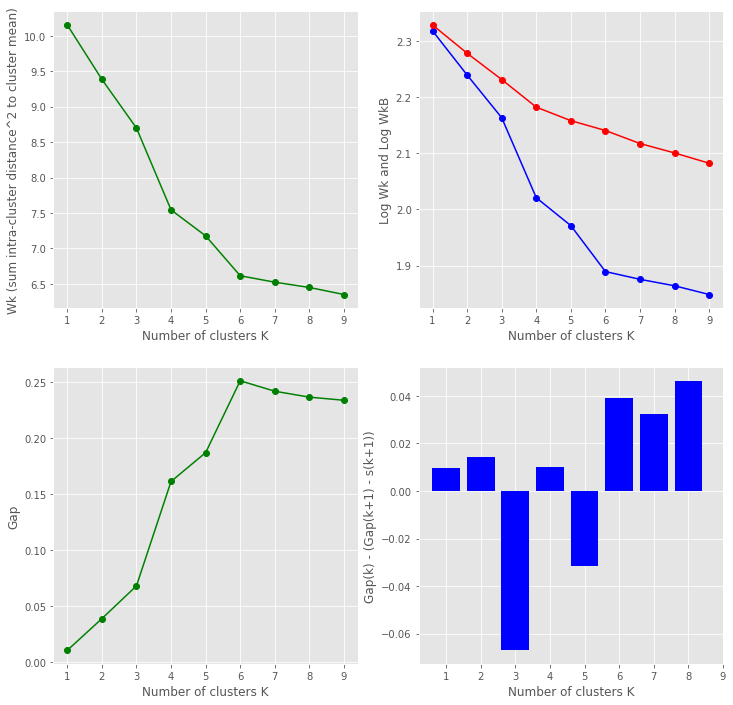

In [84]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
# First plot Wk vs Ks
ax1 = axs[0][0]
ax1.grid(c='white')
ax1.plot(ks, Wks, 'g-o')
ax1.set(xlabel='Number of clusters K', ylabel='Wk (sum intra-cluster distance^2 to cluster mean)')

# Plot Wk and Wkbs vs Ks
ax2 = axs[0][1]
ax2.grid(c='white')
ax2.plot(ks, np.log(Wks), 'b-o', ks, np.log(Wkbs), 'r-o')
ax2.set(xlabel='Number of clusters K', ylabel='Log Wk and Log WkB')

# Plot gap vs Ks
ax3 = axs[1][0]
ax3.grid(c='white')
ax3.plot(ks, np.log(Wkbs) - np.log(Wks), 'g-o')
ax3.set(xlabel='Number of clusters K', ylabel='Gap')

# Plot gap diff b/w k and k+1 accounting for sd
ax4 = axs[1][1]
gaps = np.log(Wkbs) - np.log(Wks)
adjusted_gaps = gaps - (np.roll(gaps, -1) - np.roll(sk, -1))
ax4.bar(ks[: -1], adjusted_gaps[: -1], 0.8, alpha=1.0, color='b')
ax4.set_xticks(ks)
ax4.set(xlabel='Number of clusters K', ylabel='Gap(k) - (Gap(k+1) - s(k+1))')

plt.show()

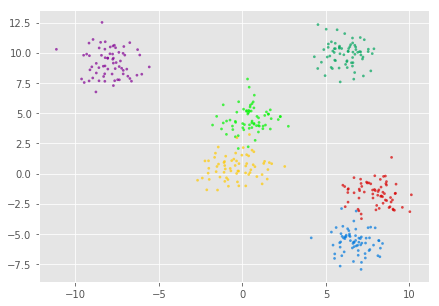

In [91]:
fig, ax = plt.subplots(1, figsize=(7, 5))
colors = cm.spectral((y + 0.5).astype(float) / len(np.unique(y)))     
ax.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
plt.show()